# Facial Emotion Recognition
<hr>

## **Introduction**
The following notebook demonstrates the classification of facial images according to the emotions they convey using a convolutional neural network of images with the <a href = "https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">FER2013</a> dataset.

The notebook has been divided into following parts:

*    Preprocessing
*    Training the model
*    Testing the model
*    Results

<hr>

## **Dataset**
<a href = "https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">FER2013</a> is an open-source dataset shared publicly for a Kaggle competition.
This dataset consists of 35,887 grayscale, 48x48 sized face images labelled with 7 emotions.
Emotion labels in the dataset:
<table>
    <th>Emotion</th><th>Number of images</th>
    <tr><td>Angry</td><td>4593</td></tr>
    <tr><td>Disgust</td><td>547</td></tr>
    <tr><td>Fear</td><td>5121</td></tr>
    <tr><td>Happy</td><td>8989</td></tr>
    <tr><td>Sad</td><td>6077</td></tr>
    <tr><td>Surprise</td><td>4002</td></tr>
    <tr><td>Neutral</td><td>6198</td></tr>
</table>

<hr>

## Preprocessing

### **Importing Libraries**
The following libraries are needed. They can be installed by pip install \<lib-name>
*   *pandas* for data analysis and manipulation
*   *numpy* for array based operations

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('D:/Scrap/32145/ESMP/fer2013/fer2013.csv')

In [3]:
width, height = 48, 48

In [4]:
datapoints = data['pixels'].tolist()

In [5]:
# datapoints

### Acquire data features for training

Since 'datapoints' is a list of Strings with space-separated pixel values of each image, they need to be converted to an array with the integer pixel values.
<br>Each numpy array represents an image.
<br>They are then reshaped to match the dataset input specifications and converted to float.


In [6]:
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

In [7]:
X = np.asarray(X)
X = np.expand_dims(X, -1) #insert a new axis at the -1 position in the expanded array shape

### Getting labels for training

In [8]:
y = pd.get_dummies(data['emotion']).as_matrix()

In [9]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

### Store data and labels

In [10]:
np.save('dataX', X)
np.save('labels', y)

In [11]:
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+str(len(y[0])))
print("Number of examples in dataset: "+str(len(X)))
print("X,y stored in dataX.npy and labels.npy respectively")

Number of Features: 48
Number of Labels: 7
Number of examples in dataset: 35887
X,y stored in dataX.npy and labels.npy respectively


<hr>

## Training the model

### **Importing Libraries**
The following libraries are needed. They can be installed by pip install \<lib-name>
*   *sys* and *os* for file related operations
*   *sklearn* for splitting the dataset into train, test and validation
*   *keras* for developing and evaluating deep learning models 
*   *matplotlib* for plotting

In [12]:
# !pip install keras
# !pip install tensorflow

In [13]:
import sys, os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
from matplotlib import pyplot as plt

### CNN model specification values:

In [46]:
num_features = 64
num_labels = 7
batch_size = 512 #64
epochs = 100 
# epochs = 2 
width, height = 48, 48

In [15]:
x = np.load('./dataX.npy')
y = np.load('./labels.npy')

### Standardize each column value and center around zero
Hence, the pixel values will roughly be in a [-1, +1] interval and around 0

In [16]:
x -= np.mean(x, axis=0) #column mean is now centered around 0
x /= np.std(x, axis=0)  #reduce the spread of the data around this 0

### Displaying the first 10 images from the dataset

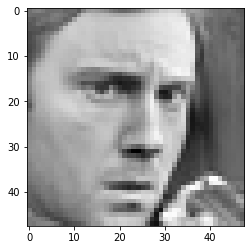

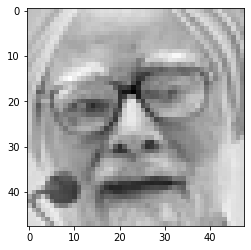

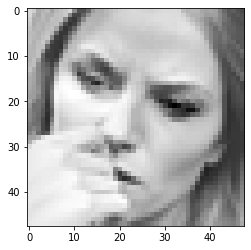

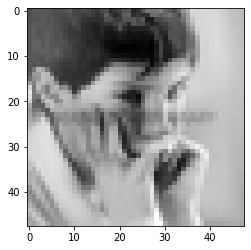

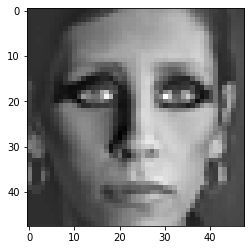

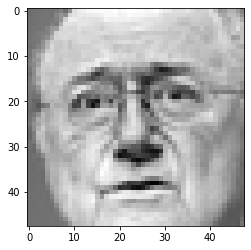

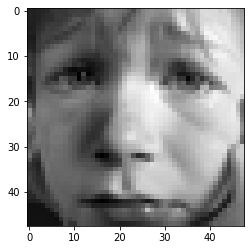

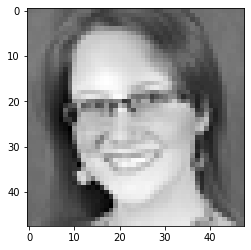

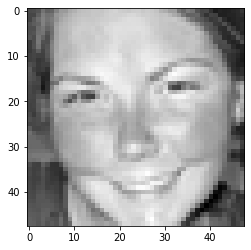

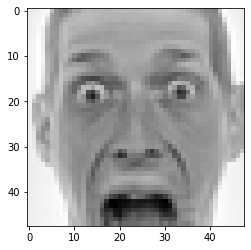

In [17]:
for xx in range(10):
   plt.figure(xx)
   plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

### Splitting data into train, validation and test data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [19]:
#test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

### CNN Model Design

#### Layers:
*   *Conv2D* for spatial convolution over images
*   *MaxPooling2D* for downsampling by taking the maximum value over an input window
*   *Dropout* to randomly dropout features 
*   *BatchNormalization* to standardize the input and regularization, thus reducing generalization error
*   *Flatten* for converting the data into a 1-dimensional array
*   *Dense* for connecting neural network layer

#### Activation:
*   *reLU* (Rectified Linear Unit)
<br>
$ f(x) = max(0,x) $

#### Loss Function:
*   *categorical_crossentropy* for spatial convolution over images
<br>
$ f(x) = y_i log(p_i) + (1-y_i)log(1-p_i) $

#### Optimizer:
*   *Adam* for for stochastic gradient descent for training deep learning models

#### Regularizer:
*   *l2* for reduce the likelihood of model overfitting(keeps weight and bias values small)

#### Callbacks:
*   *ReduceLROnPlateau* to reduce learning rate when a metric has stopped improving
*   *TensorBoard* for tracking and visualizing metrics
*   *EarlyStopping* to stop training when a monitored metric has stopped improving
*   *ModelCheckpoint* to save a model or weights to be loaded later
<br><br>
<p>
    
  <img width="520" height="400" src="https://scx1.b-cdn.net/csz/news/800a/2019/threecnnmode.jpg">
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    Fig: CNN Model Structure Source:
<!--     <a href="https://scx1.b-cdn.net/csz/news/800a/2019/threecnnmode.jpg"> -->
      <a href="https://scx1.b-cdn.net/csz/news/800a/2019/threecnnmode.jpg">techxplore.com</a>
<!--     </a> -->
</p>

*Convolution* 
-    extract features from an input image
-    preserves the relationship between pixels by learning image features using small squares of input data
-    mathematical operation that takes two inputs such as image matrix and a filter or kernel

In [24]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

### Summary of the model

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 23, 23, 128)      

### Compliling the model with adam optimixer and categorical crossentropy loss function

In [26]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

### Training the model

In [47]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

Epoch 1/100
57/57 [==============================] - 1021s 18s/step - loss: 0.7727 - accuracy: 0.7227 - val_loss: 1.0205 - val_accuracy: 0.6492
Epoch 2/100
28/57 [=============>................] - ETA: 8:30 - loss: 0.7396 - accuracy: 0.7335

KeyboardInterrupt: 

### Saving the  model to be used later

In [48]:
#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Saved model to disk


# Testing the CNN Model


### **Importing Libraries**
The following libraries are needed. They can be installed by pip install \<lib-name>
*   *__future__* will change the / operator to mean true division throughout the module

### Loading json file and creating model

In [3]:
from __future__ import division

In [4]:
json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

NameError: name 'model_from_json' is not defined

### Load weights into new model

In [51]:
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

Loaded model from disk


In [52]:
truey=[]
predy=[]

In [53]:
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

In [54]:
yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

In [55]:
for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

In [56]:
acc = (count/len(y))*100

In [57]:
#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

Predicted and true label values saved
Accuracy on test set :64.44692114795207%


# Results

## Confusion Matrix

### **Importing Libraries**
The following libraries are needed. They can be installed by pip install \<lib-name>
*   *confusion_matrix* to create confusion matrix
*   *itertools* to  iterate over data structures

In [58]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [59]:
y_true = np.load('./truey.npy')
y_pred = np.load('./predy.npy')

In [60]:
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

[[251   1  31  27  99   8  81]
 [ 24  16   4   0   5   1   2]
 [ 51   4 179  29 167  50  65]
 [ 25   0   3 761  34  14  44]
 [ 38   0  26  23 371   1 129]
 [  9   0  49  34  11 296  15]
 [ 22   0  13  43  92   2 439]]


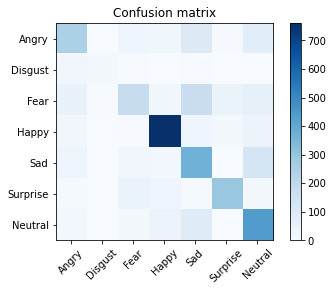

In [61]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.

In [62]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55       498
           1       0.76      0.31      0.44        52
           2       0.59      0.33      0.42       545
           3       0.83      0.86      0.85       881
           4       0.48      0.63      0.54       588
           5       0.80      0.71      0.75       414
           6       0.57      0.72      0.63       611

    accuracy                           0.64      3589
   macro avg       0.66      0.58      0.60      3589
weighted avg       0.65      0.64      0.64      3589



# Testing on custom images

In [ ]:
# load json and create model

In [1]:
import cv2

In [5]:
# #loading the model
# json_file = open('fer.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

In [66]:
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

Loaded model from disk


In [67]:
#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [71]:
webcam = cv2.VideoCapture(0) 

In [ ]:
ret, frame = webcam.read()         # reading frames
print (ret)                        # Checking if frame captured or not
webcam.release()                   # releasing the webcam

In [3]:
import cv2

camera = cv2.VideoCapture(0)
for i in range(10):
    return_value, image = camera.read()
    cv2.imwrite('test.jpg', image)
del(camera)

In [6]:
# #loading image
# full_size_image = cv2.imread("test.jpg")
# print("Image Loaded")
# gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
# face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# faces = face.detectMultiScale(gray, 1.3  , 10)

In [ ]:
#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

In [ ]:
cv2.imshow('Emotion', full_size_image)
cv2.waitKey()